In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install cloudscraper -q

import urllib
import re
from urllib.request import Request, urlopen
from bs4 import BeautifulSoup
import requests
import json
import networkx as nx
import csv
import pandas as pd
import math
import itertools
from itertools import permutations, repeat
import re
import matplotlib.pyplot as plt
import copy
import cloudscraper


#%matplotlib notebook

# FIFA Autobuilder

## V1

In [38]:
def chemistry_checker(futbin_squad,subs=False,top_n=10,save=False):
    
    # web scraper - takes a futbin squad and extracts the player information
    
    scraper = cloudscraper.create_scraper()

    html = scraper.get(futbin_squad).text
    soup = BeautifulSoup(html, 'html.parser')

    player_list = []
    sub_list = []

    urls = soup.findAll('div', {'class':"cardetails"})

    for url in urls[:11]:
        player_list.append("https://www.futbin.com"+re.findall('"([^"]*)"',str(url).split('\n')[1])[0])

    urls = soup.findAll('div', {'class':"card cardnum added"})
    for url in urls:   
        try:
            sub_list.append("https://www.futbin.com"+re.findall('"([^"]*)"',str(url).split('\n')[5])[0])
        except:
            break

    player_dicts = {}

    for player in player_list:
        html = scraper.get(player).text
        soup = BeautifulSoup(html, 'html.parser')

        name = soup.find('div', {'class':"pcdisplay-name"}).text

        temp_dict = {}

        temp_dict['Position'] = soup.find('div', {'class':"pcdisplay-pos"}).text
        temp_dict['Rating'] = soup.find('div', {'class':"pcdisplay-rat"}).text

        table = soup.find('table', {'class':"table-info" })
        
        data_types = ['Club','Nation','League','Revision']

        for row in table.findAll("tr"):
            try:
              data_type = row.find("th").text
              data = row.find("td").text
              if data_type in data_types:
                  temp_dict[data_type] = data.strip()
            except:
              pass

        player_dicts[name] = temp_dict

    sub_dicts = {}

    for player in sub_list:
        html = scraper.get(player).text
        soup = BeautifulSoup(html, 'html.parser')

        name = soup.find('div', {'class':"pcdisplay-name"}).text

        temp_dict = {}

        temp_dict['Position'] = soup.find('div', {'class':"pcdisplay-pos"}).text
        temp_dict['Rating'] = soup.find('div', {'class':"pcdisplay-rat"}).text

        table = soup.find('table', {'class':"table-info" })
        data_types = ['Club','Nation','League','Revision']

        for row in table.findAll("tr"):
            try:
              data_type = row.find("th").text
              data = row.find("td").text
              if data_type in data_types:
                  temp_dict[data_type] = data.strip()
            except:
              pass

        sub_dicts[name] = temp_dict
        
    # adds subs player data if sub=True
        
    if subs == False:
        players_list = [player_dicts]
    else:
        player_dicts.update(sub_dicts)
        players_list = []
        for subset in itertools.combinations(player_dicts, 11):
            temp = {}
            for name in subset:
                temp[name] = player_dicts[name]

            players_list.append(temp)
    
    if len(player_dicts) > 17:
        print("Too many subsitutes. Max = 6")
        return
    
    # link strength calculator function
    
    def calc_link_strength(player_1,player_2):
        if player_1['Club'] == 'Icons' and player_2['Club'] == 'Icons':
            if player_1['Nation'] == player_2['Nation']:
                link_strength = 3
            else:
                link_strength = 2

        elif player_1['Club'] == 'Icons' or player_2['Club'] == 'Icons':
            if player_1['Nation'] == player_2['Nation']:
                link_strength = 2
            else:
                link_strength = 1

        else:
            if player_1['Nation'] != player_2['Nation'] and player_1['League'] != player_2['League'] and player_1['Club'] != player_2['Club']:
                link_strength = 0
            elif player_1['Nation'] == player_2['Nation'] and player_1['League'] != player_2['League'] and player_1['Club'] != player_2['Club']:
                link_strength = 1
            elif player_1['Nation'] != player_2['Nation'] and player_1['League'] == player_2['League'] and player_1['Club'] != player_2['Club']:
                link_strength = 1
            elif player_1['Nation'] != player_2['Nation'] and player_1['League'] != player_2['League'] and player_1['Club'] == player_2['Club']:
                link_strength = 2
            elif player_1['Nation'] == player_2['Nation'] and player_1['League'] == player_2['League'] and player_1['Club'] != player_2['Club']:
                link_strength = 2
            elif player_1['Nation'] == player_2['Nation'] and player_1['League'] != player_2['League'] and player_1['Club'] == player_2['Club']:
                link_strength = 2
            elif player_1['Nation'] != player_2['Nation'] and player_1['League'] == player_2['League'] and player_1['Club'] == player_2['Club']:
                link_strength = 2
            elif player_1['Nation'] == player_2['Nation'] and player_1['League'] == player_2['League'] and player_1['Club'] == player_2['Club']:
                link_strength = 3

        return link_strength
    
    # position categories of each position
    
    pos_category= {
        'Central':['ST','CF','CAM','CM','CDM','LAM','RAM','LCM','RCM','LST','RST','LDM','RDM'],
        'Left':['LF','LW','LM'],
        'Right':['RF','RW','RM'],
        'Left Back':['LB','LWB'],
        'Right Back':['RB','RWB'],
        'Centre Back':['CB','LCB','RCB'],
        'Goalkeeper':['GK']
    }
    
    # load in formation metadata
    
    with open('drive/My Drive/fifa_autobuilder/formations.json') as f:
        formations_json = json.load(f)
        
    print("Possible combinations:",len(players_list)*len(formations_json))
    
    comb_list = []
    for players in players_list:

        player_pos = {}

        for key in pos_category.keys():
            player_pos[key] = {'count':0,
                                     'players':[]}

        for player in players:
            for pos in pos_category.keys():
                if players[player]['Position'] in pos_category[pos]:
                    player_pos[pos]['count'] += 1
                    player_pos[pos]['players'].append(player)
                    break

        for formation in formations_json:

            formation_pos = {}
            for key in pos_category.keys():
                formation_pos[key] = {'count':0,
                                            'pos':[]}

            for f_pos in list(formations_json[formation]['pos'].keys()):
                for pos in pos_category.keys():
                    if f_pos in pos_category[pos]:
                        formation_pos[pos]['count'] += 1
                        formation_pos[pos]['pos'].append(f_pos)
                        break

            # check to see whether formation positions matches available player positions
            
            match = True
            for pos_cat in formation_pos:
                if formation_pos[pos_cat]['count'] != player_pos[pos_cat]['count']:
                    match = False
                    break
                    
            # assigns player to formation and calculates individual/team chemistry and team rating        
            
            if match == True:
                G = nx.Graph() 

                G.add_edges_from(formations_json[formation]['edges'])
                graph_pos = formations_json[formation]['pos']

                combinations = []

                for item in player_pos:
                    if player_pos[item]['count'] != 1:
                        if not combinations:
                            combinations = list(list(zip(r, p)) for (r, p) in zip(repeat(player_pos[item]['players']), permutations(formation_pos[item]['pos'])))
                            length = len(combinations)
                        else:
                            copy_comb = combinations[:]
                            for i in range(math.factorial(player_pos[item]['count'])-1):
                                for j in range(length):
                                    combinations.append(copy_comb[i][:])

                            additions = list(list(zip(r, p)) for (r, p) in zip(repeat(player_pos[item]['players']), permutations(formation_pos[item]['pos'])))

                            nxt = 0
                            for add in additions:
                                for i in range(nxt,(nxt+length)):
                                    combinations[i]+=add

                                nxt += length

                for item in player_pos:
                    if player_pos[item]['count'] == 1:
                        for comb in combinations:
                            comb.append((player_pos[item]['players'][0],formation_pos[item]['pos'][0]))


                for comb in combinations:
                    temp_comb = {'players':[],'formation':formation,'chemistry':0, 'rating':0,'full_chem':0}
                    for player_1 in comb:
                        player_dict = {'name':player_1[0],'pos':player_1[1]}
                        temp_comb['rating']+=int(players[player_1[0]]['Rating'])/11
                        linked_pos = list(dict(G.adj[player_1[1]]).keys())
                        links = 0
                        for pos in linked_pos:
                            for player_2 in comb:
                                if player_2[1] == pos:
                                    links += calc_link_strength(players[player_1[0]],players[player_2[0]])

                        if links/len(linked_pos) > 1.6:
                            player_dict['chemistry'] = 10
                            temp_comb['chemistry'] += 10
                        elif links/len(linked_pos) <= 1.6 and links/len(linked_pos) >= 1:
                            player_dict['chemistry'] = 9
                            temp_comb['chemistry'] += 9
                        elif links/len(linked_pos) <= 1 and links/len(linked_pos) >= 0.3:
                            player_dict['chemistry'] = 6
                            temp_comb['chemistry'] += 6
                        elif links/len(linked_pos) < 0.3:
                            player_dict['chemistry'] = 3
                            temp_comb['chemistry'] += 3
                        
                        if player_dict['chemistry'] < 9:
                            temp_comb['full_chem'] += 1
                        
                        temp_comb['players'].append(player_dict)
                        
                    if temp_comb['chemistry'] > 100:
                        temp_comb['chemistry'] = 100
                        
                    temp_comb['rating'] += temp_comb['chemistry']
                    
                    comb_list.append(temp_comb)
                    
    if not comb_list:
        print("No suitable formations")
    else:
        
        # sort solutions by team chemistry and plot top_n best solutions
        
        best_comb_chem = sorted(comb_list, key = lambda i: i['chemistry'],reverse=True)
        
        fig = plt.figure(figsize=(12,(24*(top_n/10))))

        rank = 0
        for i in range(top_n):
            rank += 1
            best_comb = best_comb_chem[rank-1]
            
            G = nx.Graph() 

            G.add_edges_from(formations_json[best_comb['formation']]['edges'])
            graph_pos = copy.copy(formations_json[best_comb['formation']]['pos'])

            mapping = {}
            for player in best_comb['players']:
                txt = '{player:} ({chemistry:})'
                mapping[player['pos']] = txt.format(player=player['name'],chemistry=player['chemistry'])
                graph_pos[txt.format(player=player['name'],chemistry=player['chemistry'])] = graph_pos.pop(player['pos'])
                

            H=nx.relabel_nodes(G,mapping)

            ax = fig.add_subplot((top_n/2), 2, i+1)
            nx.draw(H, graph_pos, with_labels=True, node_color='r', font_weight='bold',font_size=10)
            ax.text(0.05,0.05, str('Formation: {}\nChemistry: {}\nRating: {}\nPlayers off chem: {}').format(best_comb['formation'],best_comb['chemistry'],int(best_comb['rating']),best_comb['full_chem'])
                    , size=10, ha="left", transform=ax.transAxes)
            ax.set_title(rank,loc='left',fontsize=20)
        
        plt.tight_layout()

        if save == True:
            plt.savefig("drive/My Drive/fifa_autobuilder/squads/squads-{}.png".format(futbin_squad.split('/')[-1]))
        plt.show()

Possible combinations: 39585


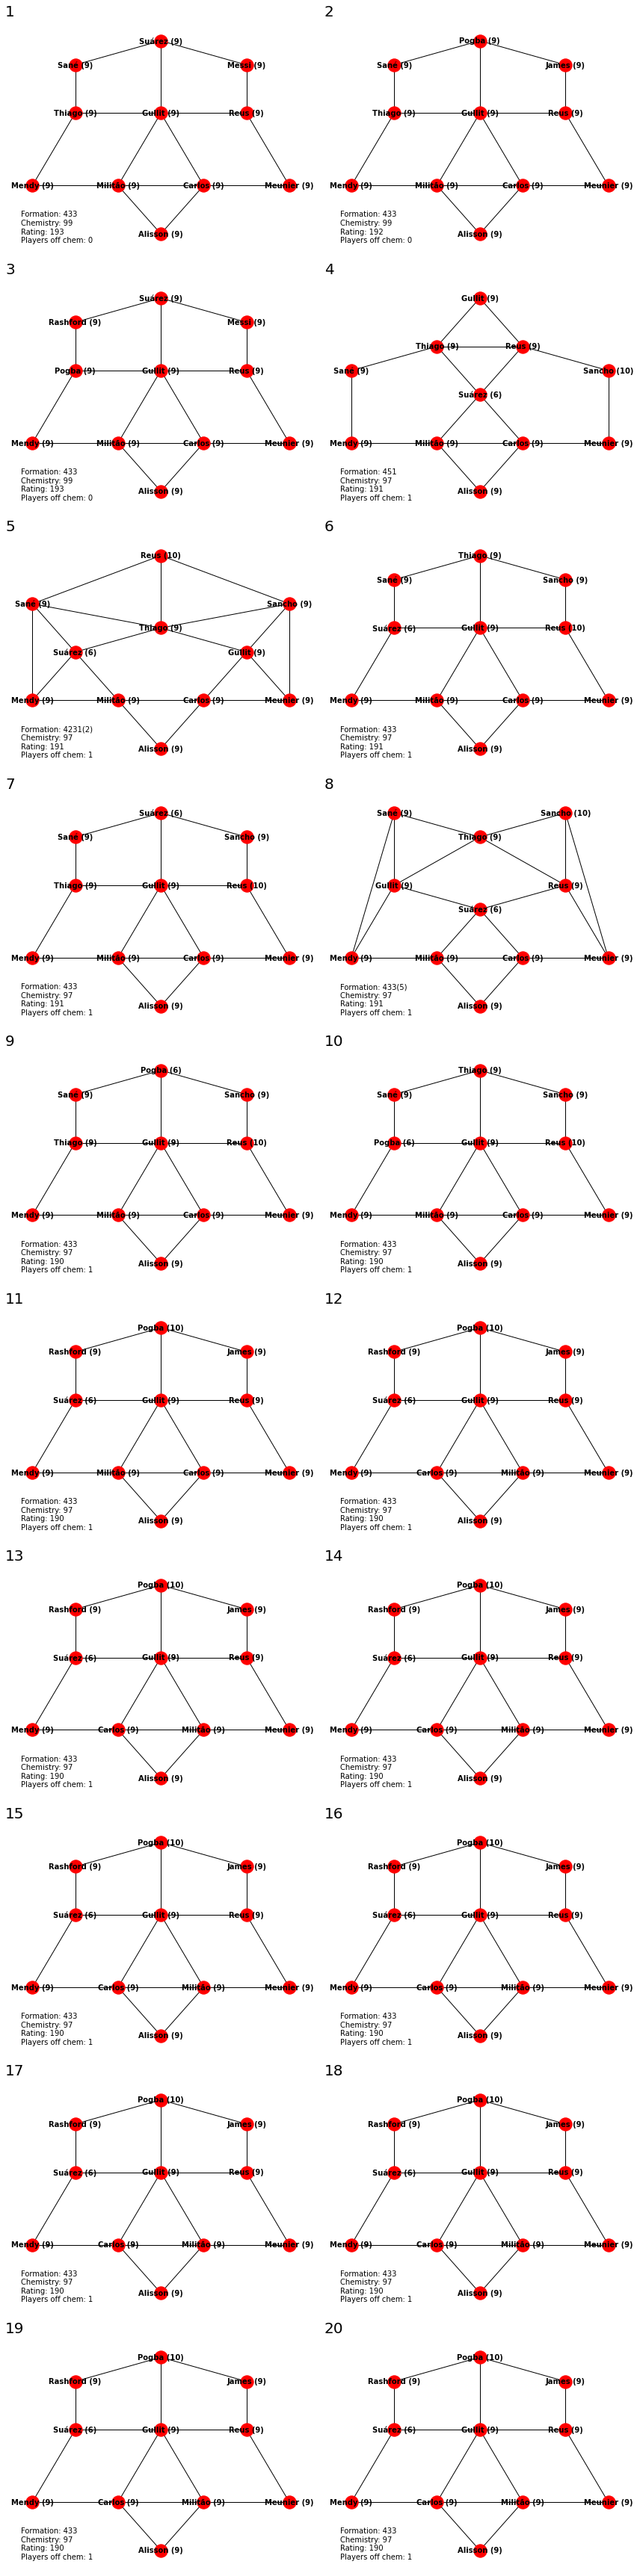

In [39]:
chemistry_checker("https://www.futbin.com/20/squad/17470206",subs=True,top_n=20)

## V2

In [ ]:
def chemistry_checker_v2(futbin_squad,subs=False,top_n=10,save=False):
    
    def make_soup(url):
        profile = requests.get(url, headers={'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/69.0.3497.100 Safari/537.36'})
        soup_data = BeautifulSoup(profile.text, 'html.parser')
        return soup_data

    soup = make_soup(futbin_squad)

    player_list = []
    sub_list = []

    urls = soup.findAll('div', {'class':"cardetails"})
    for url in urls[:11]:
        player_list.append("https://www.futbin.com"+re.findall('"([^"]*)"',str(url).split('\n')[1])[0])

    urls = soup.findAll('div', {'class':"card cardnum added"})
    for url in urls:   
        try:
            sub_list.append("https://www.futbin.com"+re.findall('"([^"]*)"',str(url).split('\n')[5])[0])
        except:
            break

    player_dicts = {}

    for player in player_list:
        soup = make_soup(player)
        name = soup.find('div', {'class':"pcdisplay-name"}).text

        temp_dict = {}

        temp_dict['Position'] = soup.find('div', {'class':"pcdisplay-pos"}).text
        temp_dict['Rating'] = soup.find('div', {'class':"pcdisplay-rat"}).text

        table = soup.find('table', {'class':"table-info" })
        data_types = ['Club','Nation','League','Revision']

        for row in table.findAll("tr"):
            data_type = row.find("th").text
            data = row.find("td").text
            if data_type in data_types:
                temp_dict[data_type] = data.strip()

        player_dicts[name] = temp_dict

    sub_dicts = {}

    for player in sub_list:
        soup = make_soup(player)
        name = soup.find('div', {'class':"pcdisplay-name"}).text

        temp_dict = {}

        temp_dict['Position'] = soup.find('div', {'class':"pcdisplay-pos"}).text
        temp_dict['Rating'] = soup.find('div', {'class':"pcdisplay-rat"}).text

        table = soup.find('table', {'class':"table-info" })
        data_types = ['Club','Nation','League','Revision']

        for row in table.findAll("tr"):
            data_type = row.find("th").text
            data = row.find("td").text
            if data_type in data_types:
                temp_dict[data_type] = data.strip()

        sub_dicts[name] = temp_dict
        
    if subs == False:
        players_list = [player_dicts]
    else:
        player_dicts.update(sub_dicts)
        players_list = []
        for subset in itertools.combinations(player_dicts, 11):
            temp = {}
            for name in subset:
                temp[name] = player_dicts[name]

            players_list.append(temp)
    
    if len(player_dicts) > 17:
        print("Too many subsitutes. Max = 6")
        return
    
    def calc_link_strength(player_1,player_2):
        if player_1['Club'] == 'Icons' and player_2['Club'] == 'Icons':
            if player_1['Nation'] == player_2['Nation']:
                link_strength = 3
            else:
                link_strength = 2

        elif player_1['Club'] == 'Icons' or player_2['Club'] == 'Icons':
            if player_1['Nation'] == player_2['Nation']:
                link_strength = 2
            else:
                link_strength = 1

        else:
            if player_1['Nation'] != player_2['Nation'] and player_1['League'] != player_2['League'] and player_1['Club'] != player_2['Club']:
                link_strength = 0
            elif player_1['Nation'] == player_2['Nation'] and player_1['League'] != player_2['League'] and player_1['Club'] != player_2['Club']:
                link_strength = 1
            elif player_1['Nation'] != player_2['Nation'] and player_1['League'] == player_2['League'] and player_1['Club'] != player_2['Club']:
                link_strength = 1
            elif player_1['Nation'] != player_2['Nation'] and player_1['League'] != player_2['League'] and player_1['Club'] == player_2['Club']:
                link_strength = 2
            elif player_1['Nation'] == player_2['Nation'] and player_1['League'] == player_2['League'] and player_1['Club'] != player_2['Club']:
                link_strength = 2
            elif player_1['Nation'] == player_2['Nation'] and player_1['League'] != player_2['League'] and player_1['Club'] == player_2['Club']:
                link_strength = 2
            elif player_1['Nation'] != player_2['Nation'] and player_1['League'] == player_2['League'] and player_1['Club'] == player_2['Club']:
                link_strength = 2
            elif player_1['Nation'] == player_2['Nation'] and player_1['League'] == player_2['League'] and player_1['Club'] == player_2['Club']:
                link_strength = 3

        return link_strength
    
    pos_category= {
        'Central':['ST','CF','CAM','CM','CDM','LAM','RAM','LCM','RCM','LST','RST','LDM','RDM'],
        'Left':['LF','LW','LM'],
        'Right':['RF','RW','RM'],
        'Left Back':['LB','LWB'],
        'Right Back':['RB','RWB'],
        'Centre Back':['CB','LCB','RCB'],
        'Goalkeeper':['GK']
    }
    
    with open('formations.json') as f:
        formations_json = json.load(f)
        
    print("Possible combinations:",len(players_list)*len(formations_json))
    
    comb_list = []
    for players in players_list:

        player_pos = {}

        for key in pos_category.keys():
            player_pos[key] = {'count':0,
                                     'players':[]}

        for player in players:
            for pos in pos_category.keys():
                if players[player]['Position'] in pos_category[pos]:
                    player_pos[pos]['count'] += 1
                    player_pos[pos]['players'].append(player)
                    break

        formation = '433'

        formation_pos = {}
        for key in pos_category.keys():
            formation_pos[key] = {'count':0,
                                        'pos':[]}

        for f_pos in list(formations_json[formation]['pos'].keys()):
            for pos in pos_category.keys():
                if f_pos in pos_category[pos]:
                    formation_pos[pos]['count'] += 1
                    formation_pos[pos]['pos'].append(f_pos)
                    break
                    
        mismatch_form = []
        mismatch_play = []

        match = True
        for pos_cat in formation_pos:
            if formation_pos[pos_cat]['count'] != player_pos[pos_cat]['count']:
                match = False
                mismatch_form.append(formation_pos[pos_cat])
                mismatch_play.append(player_pos[pos_cat])
                
    print(mismatch_form)
    print('\n')
    print(mismatch_play)

In [ ]:
chemistry_checker_v2("https://www.futbin.com/20/squad/16410959",subs=False)

NameError: name 'requests' is not defined

## Additional Info

https://www.fifauteam.com/how-is-chemistry-calculated-in-fifa-19-ultimate-team/

![image.png](attachment:image.png)

In [ ]:
link_guide = {
    'Natural':{1:10,2:9,3:6,4:3},
    'Related':{1:9,2:8,3:5,4:2},
    'Unrelated':{1:5,2:5,3:3,4:1},
    'Wrong':{1:2,2:2,3:1,4:0}
}

![image.png](attachment:image.png)

In [ ]:
pos_df = pd.read_csv("pos_data.csv", dtype=str)
pos_df.set_index('pos',inplace=True)

In [ ]:
pos_df

,GK,RB,CB,LB,RWB,LWB,CDM,CM,CAM,RM,LM,RW,LW,CF,RF,LF,ST
pos,,,,,,,,,,,,,,,,,
GK,N,W,W,W,W,W,W,W,W,W,W,W,W,W,W,W,W
RB,W,N,U,U,R,W,W,W,W,U,W,W,W,W,W,W,W
CB,W,U,N,U,W,W,U,W,W,W,W,W,W,W,W,W,W
LB,W,U,U,N,W,R,W,W,W,W,U,W,W,W,W,W,W
RWB,W,R,W,W,N,U,W,W,W,U,W,U,W,W,W,W,W
LWB,W,W,W,R,U,N,W,W,W,W,U,W,U,W,W,W,W
CDM,W,W,U,W,W,W,N,R,U,W,W,W,W,W,W,W,W
CM,W,W,W,W,W,W,R,N,R,U,U,W,W,W,W,W,W
CAM,W,W,W,W,W,W,U,R,N,W,W,W,W,R,W,W,W


In [ ]:
pos_df['GK']['GK']

'N'

In [ ]:
pos_df['RF']['RM']

'U'

### NetworkX Cheats

In [ ]:
list(G_451.nodes)

['ST', 'LAM', 'RAM', 'LM', 'RM', 'CM', 'LB', 'RB', 'LCB', 'RCB', 'GK']

In [ ]:
list(G_451.edges)

[('ST', 'LAM'),
 ('ST', 'RAM'),
 ('LAM', 'RAM'),
 ('LAM', 'LM'),
 ('LAM', 'CM'),
 ('RAM', 'RM'),
 ('RAM', 'CM'),
 ('LM', 'LB'),
 ('RM', 'RB'),
 ('CM', 'LCB'),
 ('CM', 'RCB'),
 ('LB', 'LCB'),
 ('RB', 'RCB'),
 ('LCB', 'RCB'),
 ('LCB', 'GK'),
 ('RCB', 'GK')]

In [ ]:
dict(G_451.adj['RCB']).keys()

dict_keys(['CM', 'RB', 'LCB', 'GK'])

In [ ]:
G

<IPython.core.display.Javascript object>


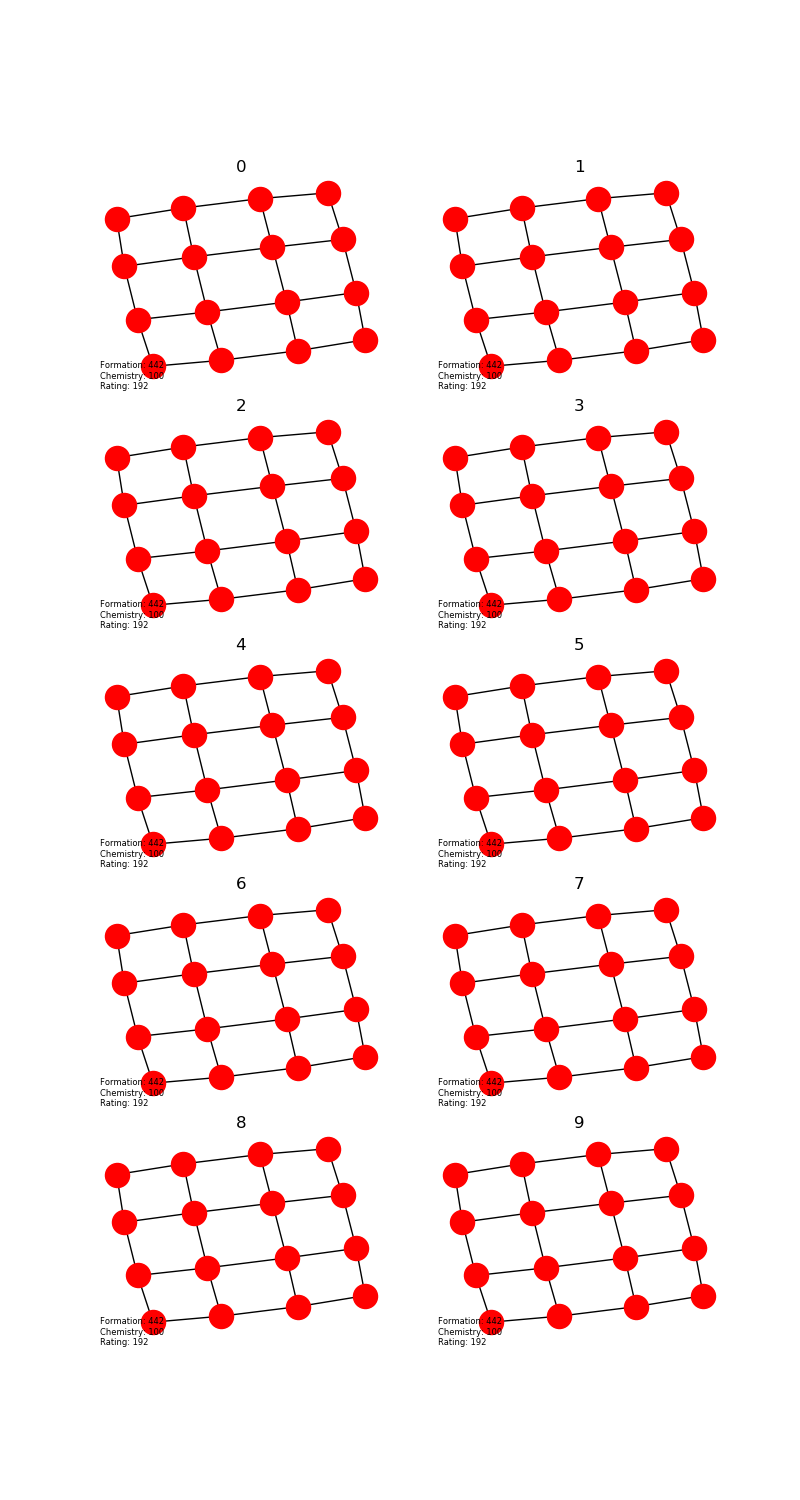

In [ ]:
G=nx.grid_2d_graph(4,4)  #4x4 grid

pos=nx.spring_layout(G,iterations=100)

fig = plt.figure(figsize=(8,15))

f = '442'
c = '100'
r = '192'

for i in range(10):
    ax = fig.add_subplot(5, 2, i+1)
    nx.draw(G,pos,node_color='r',font_size=2,ax=ax)
    ax.text(0,-0.05, str('Formation: {}\nChemistry: {}\nRating: {}').format(f,c,r), size=6, ha="left", transform=ax.transAxes)
    ax.set_title(i)

plt.savefig("squads//sqauds.png")
plt.show()

## Web Scraper

In [ ]:
def make_soup(url):
    profile = requests.get(url, headers={'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/69.0.3497.100 Safari/537.36'})
    soup_data = BeautifulSoup(profile.text, 'html.parser')
    return soup_data

In [ ]:
soup = make_soup("https://www.futbin.com/20/squad/16223908")

player_list = []
sub_list = []

urls = soup.findAll('div', {'class':"cardetails"})
for url in urls[:11]:
    player_list.append("https://www.futbin.com"+re.findall('"([^"]*)"',str(url).split('\n')[1])[0])

urls = soup.findAll('div', {'class':"card cardnum added"})
for url in urls:   
    try:
        sub_list.append("https://www.futbin.com"+re.findall('"([^"]*)"',str(url).split('\n')[5])[0])
    except:
        break

players = {}

for player in player_list:
    soup = make_soup(player)
    name = soup.find('div', {'class':"pcdisplay-name"}).text

    temp_dict = {}

    temp_dict['Position'] = soup.find('div', {'class':"pcdisplay-pos"}).text
    temp_dict['Rating'] = soup.find('div', {'class':"pcdisplay-rat"}).text

    table = soup.find('table', {'class':"table-info" })
    data_types = ['Club','Nation','League','Revision']

    for row in table.findAll("tr"):
        data_type = row.find("th").text
        data = row.find("td").text
        if data_type in data_types:
            temp_dict[data_type] = data.strip()

    players[name] = temp_dict
    
subs = {}

for player in sub_list:
    soup = make_soup(player)
    name = soup.find('div', {'class':"pcdisplay-name"}).text

    temp_dict = {}

    temp_dict['Position'] = soup.find('div', {'class':"pcdisplay-pos"}).text
    temp_dict['Rating'] = soup.find('div', {'class':"pcdisplay-rat"}).text

    table = soup.find('table', {'class':"table-info" })
    data_types = ['Club','Nation','League','Revision']

    for row in table.findAll("tr"):
        data_type = row.find("th").text
        data = row.find("td").text
        if data_type in data_types:
            temp_dict[data_type] = data.strip()

    subs[name] = temp_dict

## Formation Adder

<IPython.core.display.Javascript object>


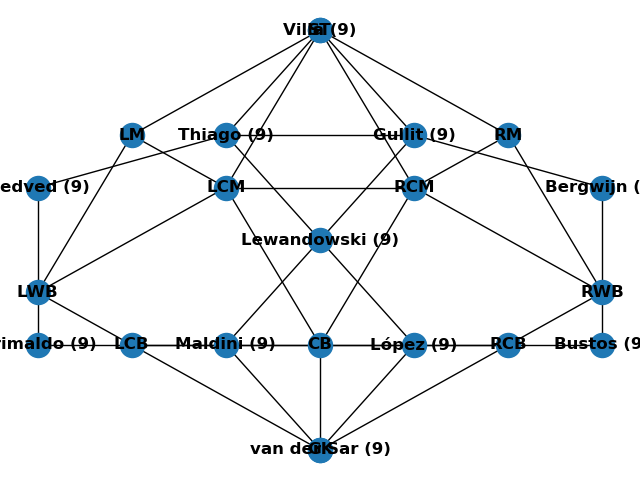

In [ ]:
G = nx.Graph() 

G.add_edges_from([
    ('LM', 'ST'),
    ('LM', 'LCM'),
    ('LM', 'LWB'),
    ('RM', 'ST'),
    ('RM', 'RCM'),
    ('RM', 'RWB'),
    ('ST', 'LCM'),
    ('ST', 'RCM'),
    ('LWB', 'LCM'),
    ('RWB', 'RCM'),
    ('LWB', 'LCB'),
    ('RWB', 'RCB'),
    ('LCM', 'RCM'),
    ('LCM', 'CB'),
    ('RCM', 'CB'),
    ('LCB', 'CB'),
    ('LCB', 'GK'),
    ('RCB', 'CB'),
    ('RCB', 'GK'),
    ('LCB', 'GK'),
    ('CB', 'GK')
])
                  
pos = {'GK': (3, 0),'LCB': (1, 2),'CB': (3, 2),'RCB': (5, 2),'LCM': (2, 5),'RCM': (4, 5),'LWB': (0, 3),'RWB': (6, 3),'LM': (1, 6),'RM': (5, 6),'ST': (3, 8)}

nx.draw(G, pos, with_labels=True, font_weight='bold')

In [ ]:
formations['541'] = {}

formations['541']['edges'] = [
    ('LM', 'ST'),
    ('LM', 'LCM'),
    ('LM', 'LWB'),
    ('RM', 'ST'),
    ('RM', 'RCM'),
    ('RM', 'RWB'),
    ('ST', 'LCM'),
    ('ST', 'RCM'),
    ('LWB', 'LCM'),
    ('RWB', 'RCM'),
    ('LWB', 'LCB'),
    ('RWB', 'RCB'),
    ('LCM', 'RCM'),
    ('LCM', 'CB'),
    ('RCM', 'CB'),
    ('LCB', 'CB'),
    ('LCB', 'GK'),
    ('RCB', 'CB'),
    ('RCB', 'GK'),
    ('LCB', 'GK'),
    ('CB', 'GK')
]

formations['541']['pos'] = {'GK': (3, 0),'LCB': (1, 2),'CB': (3, 2),'RCB': (5, 2),'LCM': (2, 5),'RCM': (4, 5),'LWB': (0, 3),'RWB': (6, 3),'LM': (1, 6),'RM': (5, 6),'ST': (3, 8)}

In [ ]:
with open('formations.json', 'w') as fp:
    json.dump(formations, fp)

<IPython.core.display.Javascript object>


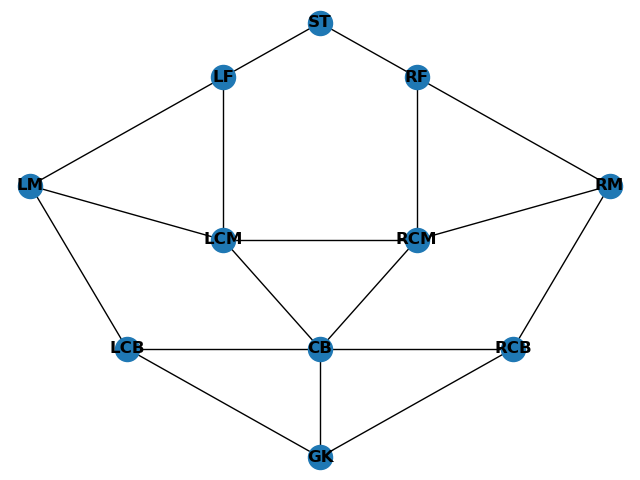

In [ ]:
with open('formations.json') as f:
    formations_json = json.load(f)

key = '3421'

G = nx.Graph() 

G.add_edges_from(formations_json[key]['edges'])
pos = formations_json[key]['pos']

nx.draw(G, pos, with_labels=True, font_weight='bold')